# 1. Подготовка

***Подгружаем библиотеки, алгоритмы и модули***

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
import time

In [7]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# 2. Анализ

***Смотрим данные***

In [8]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


***Имеем подесятимитное колличество заказов такси***

In [9]:
data.sort_index(inplace=True)

***Рядеем ряды до суммы заказов, поступивших за 1 земной час***

In [10]:
data = data.resample('1H').sum()

<span style="color:green"> Самый крутой способ)</span>

In [11]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20,5)

Populating the interactive namespace from numpy and matplotlib


***Любуемся графиком. Даа, есть кактой то тренд на увеличение числа заказов к концу года, попробуем разложить ряд***

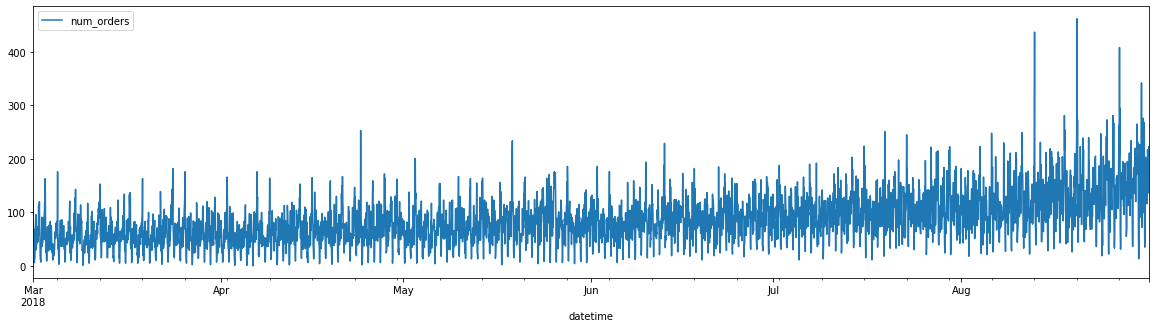

In [12]:
data.plot()

***Расскадываем, графики строим, убеждаемся в наличии тренда, но вот испльзовать эти данные не будем(. Про график сезонности  сказать нечего, а вот residuals становится более дисперный в конце графика, то есть помимо тренда на увеличения заказов наблюдается бОльший разброс в колличестве заказ***

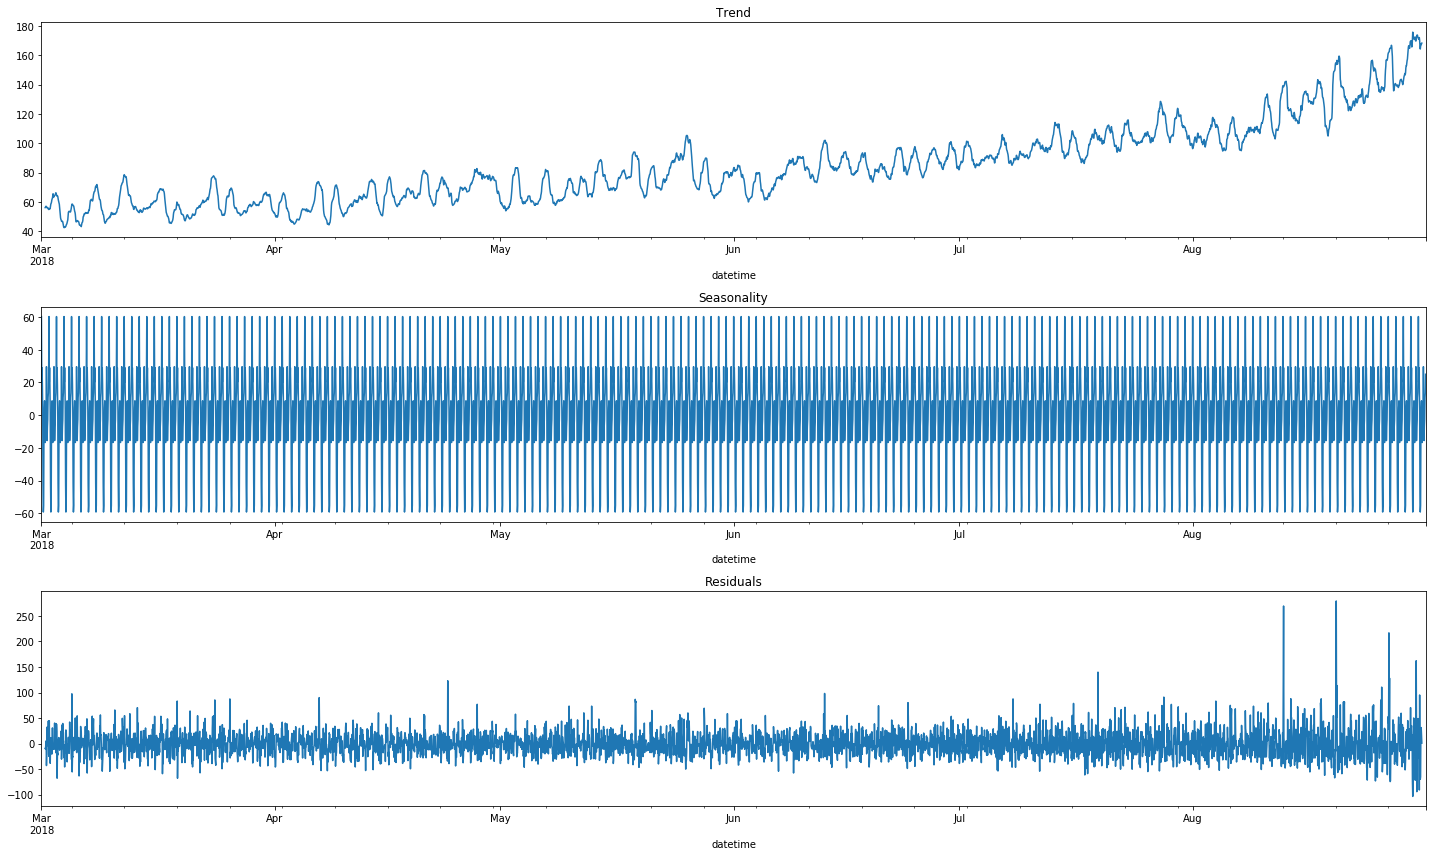

In [13]:
decomposed = seasonal_decompose(data.num_orders)
decomposed.trend # тренд
decomposed.seasonal # сезонная составляющая
decomposed.resid # остаток декомп

plt.figure(figsize=(20, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<span style="color:darkorange"> А ты точно внимательно все графики просмотрел? Про тренд ты сказал, но остальные 2 графика никак не прокомментировал </span>

***Пора делать фичи, много фичей, пишем функцию для данных по месяцу, дню, дню недели, плавающему средннему, плавающему медианному. Тут главное не заиграться***

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['delta'] = data['num_orders'] - data['num_orders'].shift()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        data['lag_-{}'.format(lag)] = data['num_orders'].shift(-lag)
       

    for rolling in range(1, rolling_mean_size + 1,2):
        data['rolling_mean_{}'.format(rolling)] = data['num_orders'].shift().rolling(rolling).mean()
        data['rolling_median_{}'.format(rolling)] = data['num_orders'].shift().rolling(rolling).median()
        


In [15]:
make_features(data, 15, 30)

***Фичей наделали, можно и от дат избавиться, а то KFold не получается настроить, если индексы в виде даты)***

In [16]:
data = data.reset_index(drop = True)

***Делим выборку на тестовую и тренирочную, как и просили в соотношении 1 к 9***

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

***Дропнуть наны не забудем***

In [18]:
train = train.dropna()

In [19]:
test = test.dropna()

***Посмотрим на статистику по фичам и убедимся, что не наделали фичей с большими значениями, которые будут сильнее остальнх влиять на обучающуюся модель***

In [20]:
train.describe()

,num_orders,month,day,dayofweek,lag_1,lag_-1,lag_2,lag_-2,lag_3,lag_-3,...,rolling_mean_21,rolling_median_21,rolling_mean_23,rolling_median_23,rolling_mean_25,rolling_median_25,rolling_mean_27,rolling_median_27,rolling_mean_29,rolling_median_29
count,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,...,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000,3945.000000
mean,78.426869,5.244360,15.222307,3.024588,78.401774,78.449937,78.394677,78.491508,78.377186,78.526236,...,78.230901,76.816984,78.207946,76.688213,78.184507,76.640051,78.162653,76.605830,78.143464,76.558428
std,38.694305,1.572974,8.831072,2.008515,38.700088,38.681222,38.700161,38.696837,38.686093,38.694136,...,19.746033,19.825582,19.389884,19.477275,19.243500,19.240780,19.229665,19.246322,19.193047,19.238210
min,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,40.666667,36.000000,41.695652,40.000000,41.920000,40.000000,41.851852,40.000000,41.241379,39.000000
25%,52.000000,4.000000,8.000000,1.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,61.666667,60.000000,62.043478,60.000000,62.280000,60.000000,62.296296,60.000000,62.275862,60.000000
50%,75.000000,5.000000,15.000000,3.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,76.952381,75.000000,76.913043,75.000000,76.720000,75.000000,76.555556,75.000000,76.379310,75.000000
75%,101.000000,7.000000,23.000000,5.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,92.619048,92.000000,92.521739,92.000000,92.720000,92.000000,92.851852,92.000000,92.655172,92.000000
max,437.000000,8.000000,31.000000,6.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,...,144.523810,138.000000,140.608696,135.000000,137.960000,131.000000,135.333333,131.000000,134.448276,131.000000


***Делим подвыборки на фичи и таргеты***

In [21]:
train_f = train.drop('num_orders',axis = 1)
train_targ = train.num_orders
test_f = test.drop('num_orders',axis = 1)
test_targ = test.num_orders

# 3. Обучение

***Тут пишем функцию, на вход которой даем название модели, тренировочные и тестовые подвыборки, и колличество Kfoldoвых операций. На выходе получим RMSE моделей проверенных на тестовой и тренировочной выбоках***

In [22]:
def score_model3(model, features, target,features_test, target_test):
    scores_train = []
    scores_test = []
    
    RMSE_train= 0
    RMSE_test = 0
    
    predicted_train = 0
    predicted_test = 0
    
    features_subtrain = 0
    target_subtrain = 0
    features_valid = 0
    target_valid = 0
    
    random_grid = 0
    #________________________________________________________________________________________
    if model in "RandomForestRegressor":
        n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10, 20]
        min_samples_leaf = [1, 2, 4, 8]
        bootstrap = [True, False]
        
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        
        rf = RandomForestRegressor()
        rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid, n_iter = 30,cv =3,
                                       verbose=0, random_state=12345, n_jobs=-1)
        rf_random.fit(features, target)
        best = rf_random.best_params_
        
        model_RFR = RandomForestRegressor(**best, random_state=12345)
        model_RFR.fit(features, target)
            
            
        predicted_train = model_RFR.predict(features)
        RMSE_train = mean_squared_error(target,predicted_train)**0.5
        scores_train.append(RMSE_train)
            
        predicted_test = model_RFR.predict(features_test)
        RMSE_test = mean_squared_error(target_test,predicted_test)**0.5
        scores_test.append(RMSE_test)
            
    #________________________________________________________________________________________
    if model in "DecisionTreeRegressor":
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10, 20]
        min_samples_leaf = [1, 2, 4, 8]
        max_features = ["auto","sqrt"]
        random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features
              }
        dt = DecisionTreeRegressor()
        dt_random = RandomizedSearchCV(estimator = dt,
                               param_distributions = random_grid,
                                       n_iter = 30,cv =3, verbose=0, random_state=12345, n_jobs=-1)
        dt_random.fit(train_f, train_targ)
        best = dt_random.best_params_
     
        model_DTR = DecisionTreeRegressor(**best, random_state=12345)
        model_DTR.fit(features,target)
            
        predicted_train = model_DTR.predict(features)
        RMSE_train = mean_squared_error(target,predicted_train)**0.5
        scores_train.append(RMSE_train)
            
        predicted_test = model_DTR.predict(features_test)
        RMSE_test = mean_squared_error(target_test,predicted_test)**0.5
        scores_test.append(RMSE_test)
    #________________________________________________________________________________________
    if model in "LinearRegression":
        fit_intercept=[True, False]
        normalize=[True, False]
        copy_X=[True,False]
        n_jobs= [-1, None]
        random_grid = {'fit_intercept': fit_intercept,
               'normalize': normalize,
               'copy_X': copy_X,
               'n_jobs': n_jobs
              }
        lr = LinearRegression()
        lr_random = RandomizedSearchCV(estimator = lr,
                               param_distributions = random_grid, n_iter = 16,cv =5, verbose=0, random_state=12345, n_jobs=-1)
        lr_random.fit(train_f, train_targ)
        best = lr_random.best_params_
            
        model_LR = LinearRegression(**best)
        model_LR.fit(features,target)
            
        predicted_train = model_LR.predict(features)
        RMSE_train = mean_squared_error(target,predicted_train)**0.5
        scores_train.append(RMSE_train)
            
        predicted_test = model_LR.predict(features_test)
        RMSE_test = mean_squared_error(target_test,predicted_test)**0.5
        scores_test.append(RMSE_test)
     #________________________________________________________________________________________
    if model in "CatBoostRegressor":
        
        iterations=[int(x) for x in np.linspace(start = 10, stop = 120, num = 5)]
        learning_rate=[float(x) for x in np.linspace(start = 0.1, stop = 1, num =4)]
        depth=[int(x) for x in np.linspace(start = 2, stop = 16, num = 4)]
        random_grid = {'iterations': iterations,
               'learning_rate': learning_rate,
               'depth': depth,
              }
       
        cbr = CatBoostRegressor()
        cbr_random = RandomizedSearchCV(estimator = cbr,
                               param_distributions = random_grid, n_iter = 1,cv =3, verbose=0, random_state=12345, n_jobs=-1)
        cbr_random.fit(features, target,verbose = False)
        best = cbr_random.best_params_

        CBR = CatBoostRegressor(**best)
        CBR.fit(features, target,verbose = False)
            
        predicted_train = CBR.predict(features)
        RMSE_train = mean_squared_error(target,predicted_train)**0.5
        scores_train.append(RMSE_train)
            
        predicted_test = CBR.predict(features_test)
        RMSE_test = mean_squared_error(target_test,predicted_test)**0.5
        scores_test.append(RMSE_test)
            

        
    print("TRAIN RMSE:",sum(scores_train) / len(scores_train)), print("TEST RMSE:", sum(scores_test) / len(scores_test))
    

# 4. Тестирование

***Тестируем 4 модели: RandomForestRegressor, DecisionTreeRegressor, LinearRegression, CatBoostRegressor.***

In [23]:
start = time.time()
score_model3('RandomForestRegressor', train_f, train_targ,test_f, test_targ);
end = time.time()
print("Time", end-start)

TRAIN RMSE: 10.453823220833032
TEST RMSE: 43.97647889031438
Time 236.46816039085388


In [24]:
start = time.time()
score_model3('DecisionTreeRegressor', train_f, train_targ,test_f, test_targ);
end = time.time()
print("Time", end-start)

TRAIN RMSE: 19.718388380849095
TEST RMSE: 62.7378829179898
Time 7.507482051849365


In [25]:
start = time.time()
score_model3('LinearRegression', train_f, train_targ,test_f, test_targ)
end = time.time()
print("Time", end-start)

TRAIN RMSE: 24.63609049394741
TEST RMSE: 43.367821439137934
Time 10.463825464248657


In [26]:
start = time.time()
score_model3('CatBoostRegressor', train_f, train_targ,test_f, test_targ)
end = time.time()
print("Time", end-start)

TRAIN RMSE: 11.766284951792368
TEST RMSE: 45.768825117261976
Time 139.70926475524902


***Вот оно, TEST RMSE: 43.367, спасибо Линейной регрессии за RMSE и отличное время***


***Выводы:***
***Гланый вывод, чтобы получить лучшее RMSE, надо подобирать фичи, а настройка гиперпараметров лишь слегка улучшает результат***
1. Подгруженные данные приведены к нужнему виду, отсортированы индексы, ряды укрупнены до 1 часа.
2. Оценена на сезонность и трендовостсть (трнед на увеличение заказов)
3. Подготовлено много фичей, почищены данные от пустых строк,  выборки разбиты на подвыборки
4. Написана функция для обучения моделей
5. Проверено 4 модели, получен необходимый результат RMSE < 48 на линейной регрессии

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48